In [1]:
import os, gc, re, time
from abc import ABCMeta, abstractmethod
from pathlib import Path
from contextlib import contextmanager
import pandas as pd
import numpy as np
import category_encoders as ce
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [2]:
os.listdir('../data/input')

CPU times: user 36.9 s, sys: 48.8 s, total: 1min 25s
Wall time: 2min 11s


In [3]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

def read_data(nrows=55000000, merge=False):
    
    print('Reading files...')
    calendar = pd.read_csv('../data/input/calendar.csv')
    sell_prices = pd.read_csv('../data/input/sell_prices.csv')
    sales_train_validation = pd.read_csv('../data/input/sales_train_validation.csv')
    submission = pd.read_csv('../data/input/sample_submission.csv')
    
    # melt sales data, get it ready for training
    _ids = ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']
    sales_train_validation = pd.melt(sales_train_validation, id_vars=_ids, var_name='day', value_name='demand')
    sales_train_validation = reduce_mem_usage(sales_train_validation)
    
    # seperate test dataframes
    test1_rows = [row for row in submission['id'] if 'validation' in row]
    test2_rows = [row for row in submission['id'] if 'evaluation' in row]
    test1 = submission[submission['id'].isin(test1_rows)]
    test2 = submission[submission['id'].isin(test2_rows)]
    
    # change column names
    d_col_1 = [f'd_{x}' for x in np.arange(1914, 1941+1, 1)]
    d_col_2 = [f'd_{x}' for x in np.arange(1942, 1969+1, 1)]
    d_col_1 = ['id'] + d_col_1
    d_col_2 = ['id'] + d_col_2
    
    test1.columns = d_col_1
    test2.columns = d_col_2
    del d_col_1, d_col_2
    
    # get product table
    product = sales_train_validation[['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']].drop_duplicates()
    
    # merge with product table
    test2['id'] = test2['id'].str.replace('_evaluation','_validation')
    test1 = test1.merge(product, how = 'left', on = 'id')
    test2 = test2.merge(product, how = 'left', on = 'id')
    test2['id'] = test2['id'].str.replace('_validation','_evaluation')
    
    test1 = pd.melt(test1, id_vars=_ids, var_name='day', value_name='demand')
    test2 = pd.melt(test2, id_vars=_ids, var_name='day', value_name='demand')
    
    sales_train_validation['part'] = 'train'
    test1['part'] = 'test1'
    test2['part'] = 'test2'
    
    data = pd.concat([sales_train_validation, test1, test2], axis=0)
    
    del sales_train_validation, test1, test2
    gc.collect()
    
    # get only a sample for fst training
    if nrows is not None:
        data = data.loc[nrows:]
    
    # drop some calendar features
    calendar.drop(['weekday', 'wday', 'month', 'year'], inplace=True, axis=1)
    
    # delete test2 for now
#     data = data[data['part'] != 'test2']
    
    if merge:
        # notebook crash with the entire dataset (maybee use tensorflow, dask, pyspark xD)
        data = pd.merge(data, calendar, how='left', left_on=['day'], right_on=['d'])
        data.drop(['d', 'day'], inplace=True, axis=1)
        # get the sell price data (this feature should be very important)
        data = data.merge(sell_prices, on=['store_id', 'item_id', 'wm_yr_wk'], how='left')
        print('Our final dataset to train has {} rows and {} columns'.format(data.shape[0], data.shape[1]))
    else: 
        pass
    
    data['date'] = pd.to_datetime(data['date'].values)
    
    gc.collect()
    
    return data

,id,d,values,store_id,item_id,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,snap,sell_price
0,HOBBIES_1_008_CA_1_validation,d_1,12,CA_1,HOBBIES_1_008,2011-01-29,11101,Saturday,1,1,2011,NaN,NaN,NaN,NaN,0,0,0,0,0.459961
1,HOBBIES_1_008_CA_1_validation,d_2,15,CA_1,HOBBIES_1_008,2011-01-30,11101,Sunday,2,1,2011,NaN,NaN,NaN,NaN,0,0,0,0,0.459961
2,HOBBIES_1_008_CA_1_validation,d_3,0,CA_1,HOBBIES_1_008,2011-01-31,11101,Monday,3,1,2011,NaN,NaN,NaN,NaN,0,0,0,0,0.459961
3,HOBBIES_1_008_CA_1_validation,d_4,0,CA_1,HOBBIES_1_008,2011-02-01,11101,Tuesday,4,2,2011,NaN,NaN,NaN,NaN,1,1,0,1,0.459961
4,HOBBIES_1_008_CA_1_validation,d_5,0,CA_1,HOBBIES_1_008,2011-02-02,11101,Wednesday,5,2,2011,NaN,NaN,NaN,NaN,1,0,1,1,0.459961


In [4]:
train.shape

(46027957, 20)

In [5]:
# 合計金額
train['sum_sell'] = train['values'] * train['sell_price']

## Store_id

In [6]:
train['store_id'].unique()

array(['CA_1', 'CA_2', 'CA_3', 'CA_4', 'TX_1', 'TX_2', 'TX_3', 'WI_1',
       'WI_2', 'WI_3'], dtype=object)

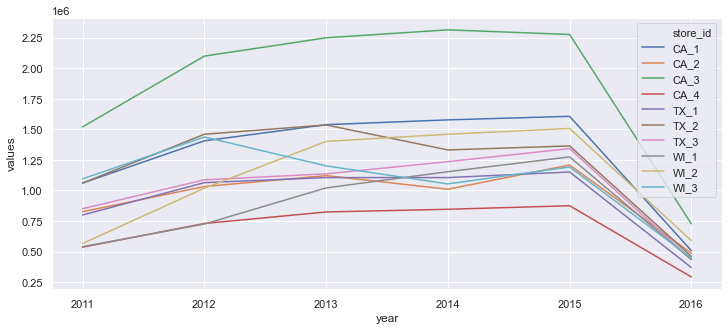

In [7]:
# 年ごとの推移
group = train.groupby(['year', 'store_id'])['values'].sum().reset_index()
fig = plt.figure(figsize=(12, 5))
sns.lineplot(x='year', y='values', hue='store_id', data=group)
plt.show()

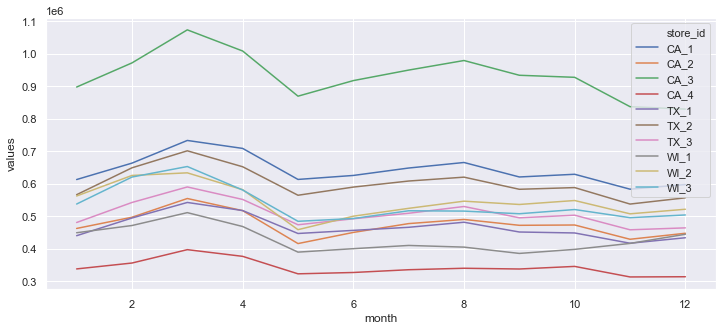

In [8]:
# 月ごとの推移
group = train.groupby(['month', 'store_id'])['values'].sum().reset_index()
fig = plt.figure(figsize=(12, 5))
sns.lineplot(x='month', y='values', hue='store_id', data=group)
plt.show()

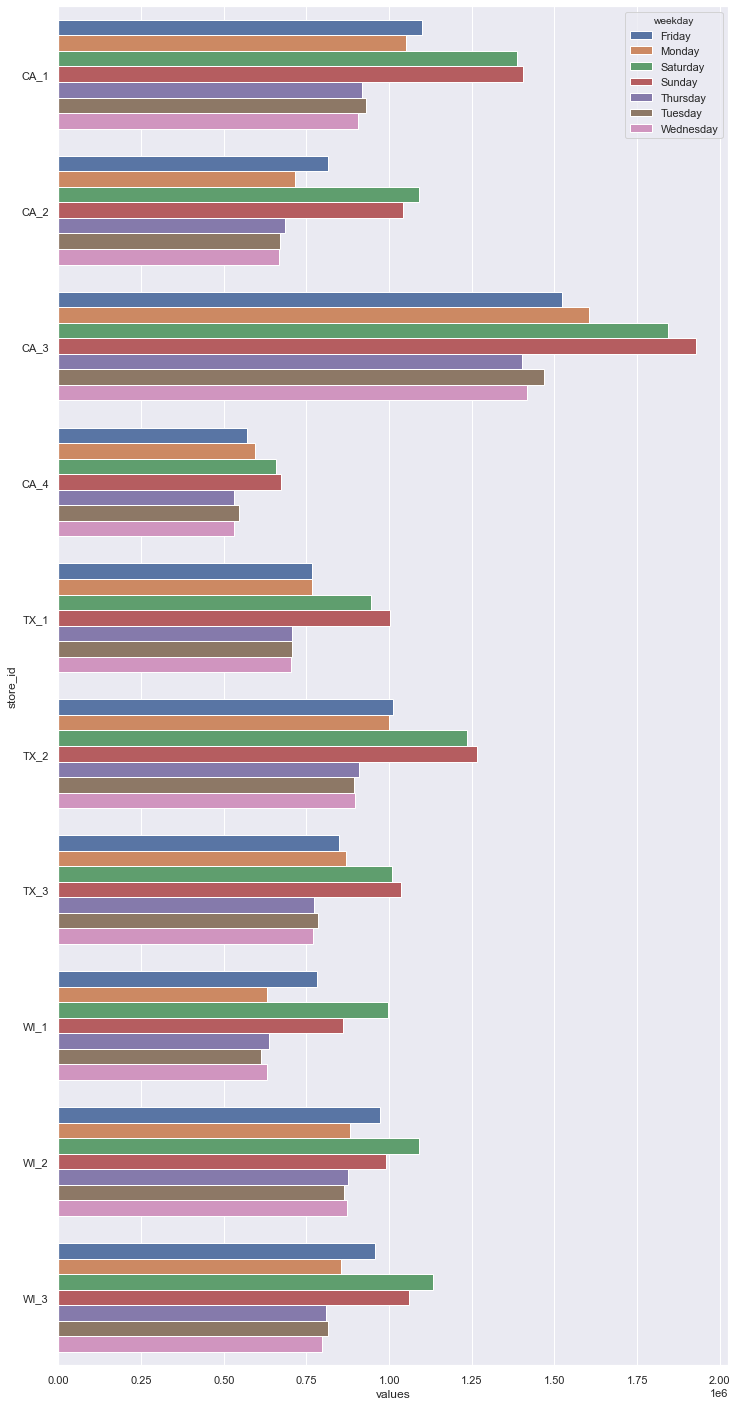

In [9]:
# 曜日ごとの推移
group = train.groupby(['weekday', 'store_id'])['values'].sum().reset_index()
fig = plt.figure(figsize=(12, 25))
sns.barplot(y='store_id', x='values', hue='weekday', data=group)
plt.show()

## item_id

In [10]:
train.head()

,id,d,values,store_id,item_id,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,snap,sell_price,sum_sell
0,HOBBIES_1_008_CA_1_validation,d_1,12,CA_1,HOBBIES_1_008,2011-01-29,11101,Saturday,1,1,2011,NaN,NaN,NaN,NaN,0,0,0,0,0.459961,5.519531
1,HOBBIES_1_008_CA_1_validation,d_2,15,CA_1,HOBBIES_1_008,2011-01-30,11101,Sunday,2,1,2011,NaN,NaN,NaN,NaN,0,0,0,0,0.459961,6.899414
2,HOBBIES_1_008_CA_1_validation,d_3,0,CA_1,HOBBIES_1_008,2011-01-31,11101,Monday,3,1,2011,NaN,NaN,NaN,NaN,0,0,0,0,0.459961,0.000000
3,HOBBIES_1_008_CA_1_validation,d_4,0,CA_1,HOBBIES_1_008,2011-02-01,11101,Tuesday,4,2,2011,NaN,NaN,NaN,NaN,1,1,0,1,0.459961,0.000000
4,HOBBIES_1_008_CA_1_validation,d_5,0,CA_1,HOBBIES_1_008,2011-02-02,11101,Wednesday,5,2,2011,NaN,NaN,NaN,NaN,1,0,1,1,0.459961,0.000000


In [11]:
# item_idごとの平均売上
temp = train.groupby('item_id')['values'].mean().reset_index()
temp['item_type'] = temp['item_id'].apply(lambda x: x.split('_')[0])
temp.head()

,item_id,values,item_type
0,FOODS_1_001,0.640433,FOODS
1,FOODS_1_002,0.383517,FOODS
2,FOODS_1_003,0.700157,FOODS
3,FOODS_1_004,8.552246,FOODS
4,FOODS_1_005,1.199121,FOODS


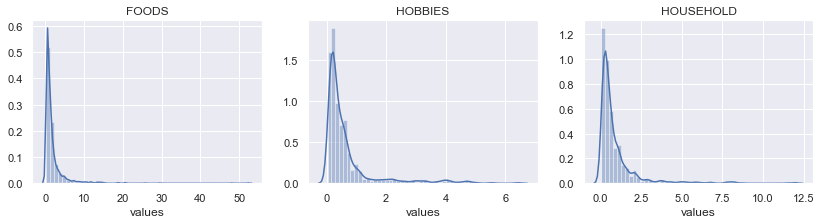

In [12]:
# 商品カテゴリごとの平均売上数のヒストグラム
# 食品の購入数がやはり多い
fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(14, 3))

for item, ax in zip(temp['item_type'].unique(), axes.ravel()):
    sns.distplot(temp[temp['item_type'] == item]['values'], ax=ax)
    ax.set_title(item)
plt.show()

In [13]:
print('Foods')
display(temp[temp['item_type'] == 'FOODS'].describe().T)
print('Hobbies')
display(temp[temp['item_type'] == 'HOBBIES'].describe().T)
print('Household')
display(temp[temp['item_type'] == 'HOUSEHOLD'].describe().T)

Foods


,count,mean,std,min,25%,50%,75%,max
values,1437.0,1.933068,3.219438,0.098646,0.566231,1.032424,1.923882,52.406116


Hobbies


,count,mean,std,min,25%,50%,75%,max
values,565.0,0.667272,0.934393,0.036561,0.182254,0.336898,0.651883,6.428122


Household


,count,mean,std,min,25%,50%,75%,max
values,1047.0,0.915027,1.341901,0.053522,0.25195,0.487257,1.025267,12.00666


In [14]:
temp.sort_values(by='values', ascending=False).head(10)

,item_id,values,item_type
702,FOODS_3_090,52.406116,FOODS
1198,FOODS_3_586,48.104652,FOODS
864,FOODS_3_252,29.550392,FOODS
1167,FOODS_3_555,25.681495,FOODS
1325,FOODS_3_714,20.709462,FOODS
1199,FOODS_3_587,20.706691,FOODS
1306,FOODS_3_694,20.386879,FOODS
732,FOODS_3_120,18.988799,FOODS
838,FOODS_3_226,18.979718,FOODS
894,FOODS_3_282,18.571386,FOODS


In [15]:
train[train['item_id'] == 'FOODS_3_090'].groupby('store_id')['values'].mean().reset_index()

,store_id,values
0,CA_1,66.493988
1,CA_2,29.361735
2,CA_3,130.947203
3,CA_4,27.320439
4,TX_1,48.972295
5,TX_2,62.465238
6,TX_3,60.038683
7,WI_1,18.218505
8,WI_2,16.764767
9,WI_3,63.478306


In [16]:
def plot_id(train, _id, from_date, to_date, date_interval=14):
    '''
    IDごとに売上数の波形を表示
    train: RawData
    _id: Target ID
    from_date: Start Date for Drawing Graph
    to_date: End Date for Drawing Graph
    date_interval: Interval of Xticks
    '''
    temp = train[train['id'] == _id].reset_index(drop=True)

    _temp = temp[temp['date'] < to_date]
    fig = plt.figure(figsize=(12, 5))
    plt.plot(_temp['date'], _temp['values'])
    plt.xticks(np.arange(0, len(_temp) + 1, date_interval), rotation=30)
    plt.show()

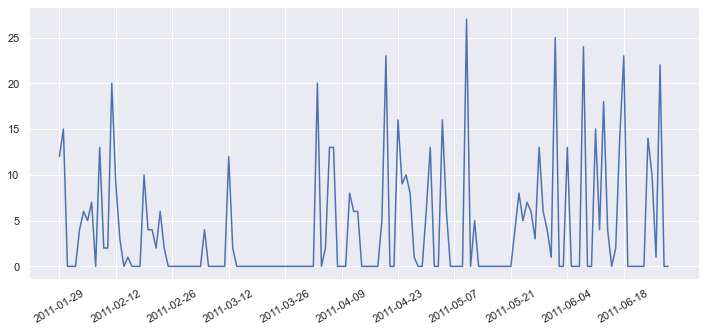

In [17]:
ids = train['id'].unique()
from_date = '2011-01-30'
to_date = '2011-06-30'

_id = ids[0]

plot_id(train, _id, from_date, to_date, date_interval=14)

In [18]:
temp.tail()

,item_id,values,item_type
3044,HOUSEHOLD_2_512,0.605354,HOUSEHOLD
3045,HOUSEHOLD_2_513,0.708621,HOUSEHOLD
3046,HOUSEHOLD_2_514,0.164844,HOUSEHOLD
3047,HOUSEHOLD_2_515,0.133691,HOUSEHOLD
3048,HOUSEHOLD_2_516,0.133421,HOUSEHOLD
